In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, f1_score
from sklearn.decomposition import PCA

In [3]:
df = pd.read_csv("C:/Users/sivas/OneDrive/Documents/GitHub/WorkflowForDataScience/datasets/model_input_flight_delay.csv")

In [4]:
df.head()

,FL_DATE,AIRLINE,AIRLINE_DOT,AIRLINE_CODE,DOT_CODE,FL_NUMBER,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,...,DELAY_DUE_CARRIER,DELAY_DUE_WEATHER,DELAY_DUE_NAS,DELAY_DUE_SECURITY,DELAY_DUE_LATE_AIRCRAFT,DELAY_STATUS,dest_state,origin_state,FL_DATE_day_name,FL_DATE_is_weekend
0,2019-03-01,Allegiant Air,Allegiant Air: G4,G4,20368,1668,PGD,Punta Gorda,SPI,Springfield,...,0.0,0.0,0.0,0.0,0.0,0,IL,FL,Friday,False
1,2021-02-16,American Airlines Inc.,American Airlines Inc.: AA,AA,19805,2437,DFW,Dallas/Fort Worth,LAX,Los Angeles,...,0.0,0.0,0.0,0.0,0.0,1,CA,TX,Tuesday,False
2,2022-04-12,PSA Airlines Inc.,PSA Airlines Inc.: OH,OH,20397,5560,EWN,New Bern/Morehead/Beaufort,CLT,Charlotte,...,0.0,0.0,0.0,0.0,0.0,0,NC,NC,Tuesday,False
3,2021-10-13,Southwest Airlines Co.,Southwest Airlines Co.: WN,WN,19393,1944,ABQ,Albuquerque,DEN,Denver,...,10.0,0.0,0.0,0.0,6.0,1,CO,NM,Wednesday,False
4,2022-06-05,Southwest Airlines Co.,Southwest Airlines Co.: WN,WN,19393,3081,PIT,Pittsburgh,STL,St. Louis,...,0.0,0.0,0.0,0.0,0.0,0,MO,PA,Sunday,True


In [6]:
# Example target column (already binary)
target = 'DELAY_STATUS'

# Choose relevant predictors
features = [
    'AIRLINE', 'ORIGIN', 'DEST',
    'CRS_DEP_TIME', 'CRS_ARR_TIME',
    'CRS_ELAPSED_TIME', 'DISTANCE',
    'FL_DATE_day_name', 'FL_DATE_is_weekend'
]

df_model = df[features + [target]].dropna()


In [14]:
df_model.head()

,AIRLINE,ORIGIN,DEST,CRS_DEP_TIME,CRS_ARR_TIME,CRS_ELAPSED_TIME,DISTANCE,FL_DATE_day_name,FL_DATE_is_weekend,DELAY_STATUS
0,Allegiant Air,PGD,SPI,630,810,160.0,994.0,Friday,False,0
1,American Airlines Inc.,DFW,LAX,1329,1500,211.0,1235.0,Tuesday,False,1
2,PSA Airlines Inc.,EWN,CLT,625,744,79.0,221.0,Tuesday,False,0
3,Southwest Airlines Co.,ABQ,DEN,1715,1835,80.0,349.0,Wednesday,False,1
4,Southwest Airlines Co.,PIT,STL,535,620,105.0,554.0,Sunday,True,0


In [7]:
X = pd.get_dummies(df_model[features], drop_first=True)  # One-hot encoding
y = df_model[target]


In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
lr = LogisticRegression(max_iter=1000, solver='liblinear')
lr.fit(X_train_scaled, y_train)

y_pred = lr.predict(X_test_scaled)
y_proba = lr.predict_proba(X_test_scaled)[:, 1]

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))

importance = pd.Series(lr.coef_[0], index=X.columns).sort_values(key=abs, ascending=False)
print(importance.head(10))

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [ ]:
lr = LogisticRegression(class_weight='balanced', max_iter=1000, solver='liblinear')

lr.fit(X_train_scaled, y_train)

y_pred = lr.predict(X_test_scaled)
y_proba = lr.predict_proba(X_test_scaled)[:, 1]

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))

importance = pd.Series(lr.coef_[0], index=X.columns).sort_values(key=abs, ascending=False)
print(importance.head(10))

Confusion Matrix:
 [[9570 6383]
 [1680 2367]]

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.60      0.70     15953
           1       0.27      0.58      0.37      4047

    accuracy                           0.60     20000
   macro avg       0.56      0.59      0.54     20000
weighted avg       0.73      0.60      0.64     20000

ROC-AUC Score: 0.6212741217169765
CRS_DEP_TIME                    0.288955
DISTANCE                        0.203020
DEST_AGS                       -0.202682
CRS_ELAPSED_TIME               -0.197148
DEST_MBS                       -0.124191
DEST_SJT                       -0.120220
ORIGIN_OME                     -0.117628
ORIGIN_STX                     -0.116396
AIRLINE_Delta Air Lines Inc.   -0.116224
DEST_EWR                        0.114470
dtype: float64


In [19]:
y_proba = lr.predict_proba(X_test_scaled)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Try a new threshold (e.g., 0.3)
new_preds = (y_proba > 0.3).astype(int)
print("ROC-AUC Score:", roc_auc_score(y_test, new_preds))

ROC-AUC Score: 0.5188562148159738


In [20]:
for solver in ['lbfgs', 'liblinear', 'saga']:
    model = LogisticRegression(solver=solver, class_weight='balanced', max_iter=1000)
    model.fit(X_train_scaled, y_train)
    score = model.score(X_test_scaled, y_test)
    print(f"{solver} accuracy: {score:.4f}")

lbfgs accuracy: 0.5968
liblinear accuracy: 0.5968
saga accuracy: 0.5964


c:\Users\sivas\OneDrive\Documents\GitHub\WorkflowForDataScience\venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [22]:
for solver in ['liblinear', 'lbfgs', 'saga']:
    model = LogisticRegression(solver=solver, class_weight='balanced', max_iter=1000)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]
    print(f"{solver} - F1: {f1_score(y_test, y_pred):.4f}, ROC-AUC: {roc_auc_score(y_test, y_proba):.4f}")


liblinear - F1: 0.3699, ROC-AUC: 0.6213
lbfgs - F1: 0.3700, ROC-AUC: 0.6213
saga - F1: 0.3692, ROC-AUC: 0.6213


c:\Users\sivas\OneDrive\Documents\GitHub\WorkflowForDataScience\venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [24]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],  # 'l1' and 'elasticnet' require saga/liblinear
    'solver': ['lbfgs']
}

grid = GridSearchCV(LogisticRegression(class_weight='balanced', max_iter=1000), param_grid, scoring='roc_auc', cv=3)
grid.fit(X_train_scaled, y_train)
print("Best AUC:", grid.best_score_)
print("Best Params:", grid.best_params_)


Best AUC: 0.6148679808175271
Best Params: {'C': 0.001, 'penalty': 'l2', 'solver': 'lbfgs'}


In [27]:
def time_of_day(hour):
    if 5 <= hour < 10:
        return 'morning'
    elif 10 <= hour < 15:
        return 'midday'
    elif 15 <= hour < 20:
        return 'evening'
    else:
        return 'late_night'

In [ ]:
df['dep_hour'] = df['CRS_DEP_TIME'] // 100
df['dep_time_bucket'] = df['dep_hour'].apply(time_of_day)
top_airports = df['ORIGIN'].value_counts().head(10).index
df['is_busy_origin'] = df['ORIGIN'].isin(top_airports).astype(int)

In [29]:
top_destinations = df['DEST'].value_counts().head(10).index
df['is_busy_destination'] = df['DEST'].isin(top_destinations).astype(int)

In [31]:
# Example target column (already binary)
target = 'DELAY_STATUS'

# Choose relevant predictors
features = [
    'AIRLINE', 'ORIGIN', 'DEST',
    'CRS_DEP_TIME', 'CRS_ARR_TIME',
    'CRS_ELAPSED_TIME', 'DISTANCE',
    'FL_DATE_day_name', 'FL_DATE_is_weekend',
    'dep_hour',
    'is_busy_origin',
    'is_busy_destination',
    'dep_time_bucket'
]

df_model = df[features + [target]].dropna()


In [32]:
X = pd.get_dummies(df_model[features], drop_first=True)  # One-hot encoding
y = df_model[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LogisticRegression(class_weight='balanced', max_iter=1000, solver="lbfgs", penalty="l2", C=0.01)
lr.fit(X_train_scaled, y_train)

y_pred = lr.predict(X_test_scaled)
y_proba = lr.predict_proba(X_test_scaled)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       0.85      0.60      0.70     15953
           1       0.27      0.59      0.37      4047

    accuracy                           0.59     20000
   macro avg       0.56      0.59      0.54     20000
weighted avg       0.73      0.59      0.63     20000

ROC-AUC: 0.6225684166661362


In [37]:
importance = pd.Series(lr.coef_[0], index=X.columns).sort_values(key=abs, ascending=False)
print(importance.head(10))

CRS_DEP_TIME                     0.147759
dep_time_bucket_morning         -0.112558
DEST_AGS                        -0.112334
AIRLINE_Delta Air Lines Inc.    -0.111296
AIRLINE_SkyWest Airlines Inc.   -0.093508
AIRLINE_Endeavor Air Inc.       -0.090082
dep_hour                         0.084853
FL_DATE_day_name_Tuesday        -0.082518
AIRLINE_Republic Airline        -0.079622
DEST_EWR                         0.078364
dtype: float64


In [40]:
minimal_cols = [
    'DELAY_STATUS',         # target
    'CRS_DEP_TIME',
    'DISTANCE',
    'CRS_ELAPSED_TIME',
    'FL_DATE_is_weekend',
    'AIRLINE'
    # optionally: 'DEST'
]

df_min = df[minimal_cols].dropna()
df_encoded = pd.get_dummies(df_min, columns=['AIRLINE'], drop_first=True)
X = df_encoded.drop('DELAY_STATUS', axis=1)
y = df_encoded['DELAY_STATUS']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LogisticRegression(class_weight='balanced', max_iter=1000)
lr.fit(X_train_scaled, y_train)

y_pred = lr.predict(X_test_scaled)
y_proba = lr.predict_proba(X_test_scaled)[:, 1]

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
importance = pd.Series(lr.coef_[0], index=X.columns).sort_values(key=abs, ascending=False)
print(importance.head(10))

Confusion Matrix:
 [[9518 6435]
 [1727 2320]]
              precision    recall  f1-score   support

           0       0.85      0.60      0.70     15953
           1       0.26      0.57      0.36      4047

    accuracy                           0.59     20000
   macro avg       0.56      0.58      0.53     20000
weighted avg       0.73      0.59      0.63     20000

ROC-AUC: 0.6177223615125547
CRS_DEP_TIME                      0.333526
CRS_ELAPSED_TIME                  0.169713
DISTANCE                         -0.139580
AIRLINE_JetBlue Airways           0.104791
AIRLINE_Delta Air Lines Inc.     -0.093860
AIRLINE_Southwest Airlines Co.    0.070185
AIRLINE_Allegiant Air             0.069353
AIRLINE_Spirit Air Lines          0.059310
AIRLINE_Endeavor Air Inc.        -0.058434
AIRLINE_American Airlines Inc.    0.058370
dtype: float64


PCA reduced from 8 to 6 components


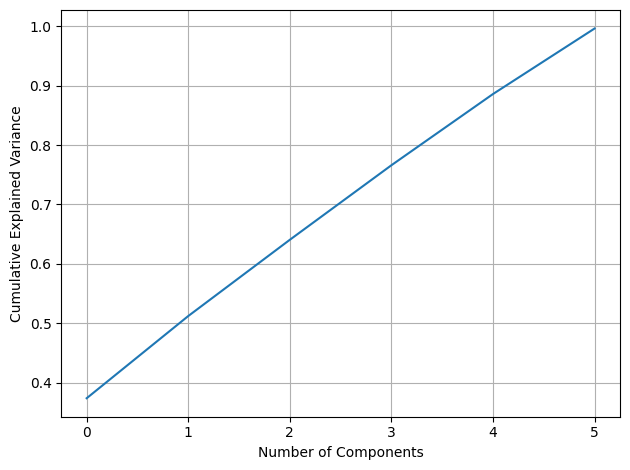

              precision    recall  f1-score   support

           0       0.98      0.94      0.96     15954
           1       0.76      0.92      0.83      3476

    accuracy                           0.93     19430
   macro avg       0.87      0.93      0.89     19430
weighted avg       0.94      0.93      0.94     19430

ROC-AUC Score: 0.9749776147274969


In [42]:
# Drop target + categorical features for PCA
numeric_cols = [
    'CRS_DEP_TIME', 'DISTANCE', 'CRS_ELAPSED_TIME',
    'DEP_DELAY', 'TAXI_OUT', 'TAXI_IN', 'AIR_TIME',
    'FL_DATE_is_weekend'
]

df_pca = df[numeric_cols + ['DELAY_STATUS']].dropna()
X_numeric = df_pca[numeric_cols]
y = df_pca['DELAY_STATUS']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)

# Try to retain 95% of variance
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

print(f"PCA reduced from {X_scaled.shape[1]} to {X_pca.shape[1]} components")

# Optional: plot explained variance
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.tight_layout()
plt.show()

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, stratify=y, test_size=0.2, random_state=42)

lr = LogisticRegression(class_weight='balanced', max_iter=1000)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
y_proba = lr.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))

In [44]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Confusion Matrix:
 [[14939  1015]
 [  294  3182]]


In [48]:
# Shape: [n_pca_components x n_original_features]
pca_components = pd.DataFrame(pca.components_, columns=numeric_cols)

# Logistic regression weights for each PCA component
lr_weights = lr.coef_[0]  # shape: [n_pca_components]

# Combine: weighted sum of component directions
feature_importance = np.dot(lr_weights, pca_components)

# Convert to Series
importance_series = pd.Series(feature_importance, index=numeric_cols).sort_values(key=abs, ascending=False)

print(importance_series.head(10))


DEP_DELAY             8.950877
TAXI_OUT              1.332400
TAXI_IN               0.899513
CRS_ELAPSED_TIME      0.074514
FL_DATE_is_weekend   -0.026957
CRS_DEP_TIME          0.025068
AIR_TIME              0.012884
DISTANCE             -0.006976
dtype: float64


PCA reduced from 7 to 5 components


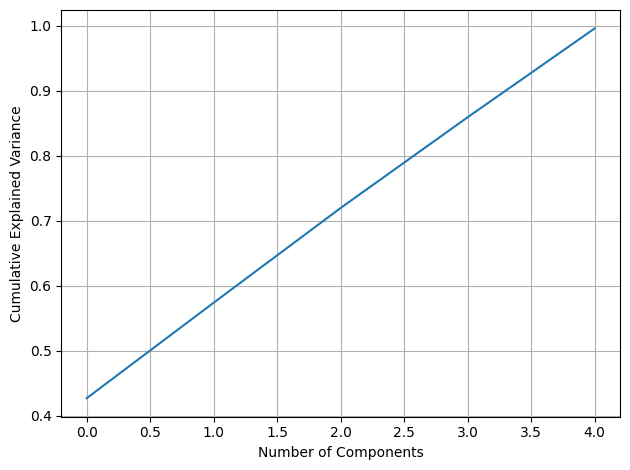

Confusion Matrix:
 [[10950  5004]
 [ 1461  2015]]
              precision    recall  f1-score   support

           0       0.88      0.69      0.77     15954
           1       0.29      0.58      0.38      3476

    accuracy                           0.67     19430
   macro avg       0.58      0.63      0.58     19430
weighted avg       0.78      0.67      0.70     19430

ROC-AUC Score: 0.6958216718577994


In [49]:
# Drop target + categorical features for PCA
numeric_cols = [
    'CRS_DEP_TIME', 'DISTANCE', 'CRS_ELAPSED_TIME',
    'TAXI_OUT', 'TAXI_IN', 'AIR_TIME',
    'FL_DATE_is_weekend'
]

df_pca = df[numeric_cols + ['DELAY_STATUS']].dropna()
X_numeric = df_pca[numeric_cols]
y = df_pca['DELAY_STATUS']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)

# Try to retain 95% of variance
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

print(f"PCA reduced from {X_scaled.shape[1]} to {X_pca.shape[1]} components")

# Optional: plot explained variance
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.tight_layout()
plt.show()

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, stratify=y, test_size=0.2, random_state=42)

lr = LogisticRegression(class_weight='balanced', max_iter=1000)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
y_proba = lr.predict_proba(X_test)[:, 1]

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))

In [50]:
# Shape: [n_pca_components x n_original_features]
pca_components = pd.DataFrame(pca.components_, columns=numeric_cols)

# Logistic regression weights for each PCA component
lr_weights = lr.coef_[0]  # shape: [n_pca_components]

# Combine: weighted sum of component directions
feature_importance = np.dot(lr_weights, pca_components)

# Convert to Series
importance_series = pd.Series(feature_importance, index=numeric_cols).sort_values(key=abs, ascending=False)

print(importance_series.head(10))


TAXI_OUT              0.539083
CRS_DEP_TIME          0.417621
TAXI_IN               0.298626
CRS_ELAPSED_TIME      0.022958
FL_DATE_is_weekend    0.013583
AIR_TIME              0.003963
DISTANCE             -0.003605
dtype: float64


PCA reduced from 5 to 3 components


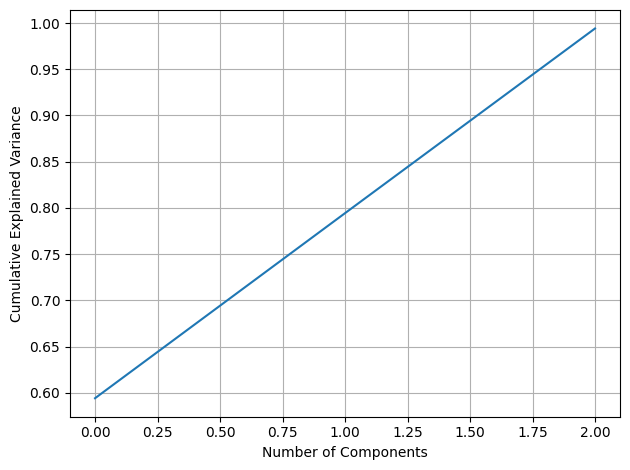

Confusion Matrix:
 [[9219 6735]
 [1378 2098]]
              precision    recall  f1-score   support

           0       0.87      0.58      0.69     15954
           1       0.24      0.60      0.34      3476

    accuracy                           0.58     19430
   macro avg       0.55      0.59      0.52     19430
weighted avg       0.76      0.58      0.63     19430

ROC-AUC Score: 0.6170341140445063
CRS_DEP_TIME          0.361330
DISTANCE              0.029015
AIR_TIME              0.026704
CRS_ELAPSED_TIME      0.025586
FL_DATE_is_weekend   -0.001580
dtype: float64


In [51]:
# Drop target + categorical features for PCA
numeric_cols = [
    'CRS_DEP_TIME', 'DISTANCE', 'CRS_ELAPSED_TIME',
    'AIR_TIME',
    'FL_DATE_is_weekend'
]

df_pca = df[numeric_cols + ['DELAY_STATUS']].dropna()
X_numeric = df_pca[numeric_cols]
y = df_pca['DELAY_STATUS']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)

# Try to retain 95% of variance
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

print(f"PCA reduced from {X_scaled.shape[1]} to {X_pca.shape[1]} components")

# Optional: plot explained variance
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.tight_layout()
plt.show()

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, stratify=y, test_size=0.2, random_state=42)

lr = LogisticRegression(class_weight='balanced', max_iter=1000)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
y_proba = lr.predict_proba(X_test)[:, 1]

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))

# Shape: [n_pca_components x n_original_features]
pca_components = pd.DataFrame(pca.components_, columns=numeric_cols)

# Logistic regression weights for each PCA component
lr_weights = lr.coef_[0]  # shape: [n_pca_components]

# Combine: weighted sum of component directions
feature_importance = np.dot(lr_weights, pca_components)

# Convert to Series
importance_series = pd.Series(feature_importance, index=numeric_cols).sort_values(key=abs, ascending=False)

print(importance_series.head(10))


PCA reduced from 16 to 10 components


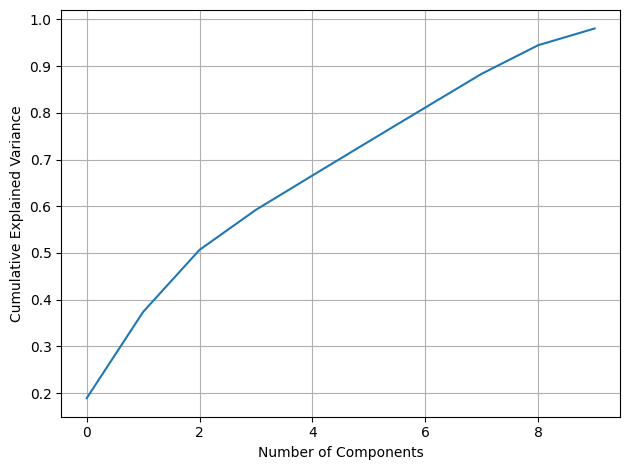

Confusion Matrix:
 [[8876 7078]
 [1295 2181]]
              precision    recall  f1-score   support

           0       0.87      0.56      0.68     15954
           1       0.24      0.63      0.34      3476

    accuracy                           0.57     19430
   macro avg       0.55      0.59      0.51     19430
weighted avg       0.76      0.57      0.62     19430

ROC-AUC Score: 0.6210186709113211
CRS_DEP_TIME                  0.145600
dep_hour                      0.145409
dep_time_bucket_morning      -0.122203
dep_time_bucket_late_night   -0.048251
dep_time_bucket_midday       -0.047601
FL_DATE_day_name_Tuesday     -0.035574
FL_DATE_day_name_Thursday     0.035218
FL_DATE_day_name_Wednesday   -0.029430
AIR_TIME                      0.029157
CRS_ELAPSED_TIME              0.028653
dtype: float64


In [72]:
# Drop target + categorical features for PCA
features = [
    'CRS_DEP_TIME', 'DISTANCE', 'CRS_ELAPSED_TIME',
    'AIR_TIME',
    'FL_DATE_is_weekend', 'dep_hour','dep_time_bucket','is_busy_destination','FL_DATE_day_name'
]

df_subset = df[features + ['DELAY_STATUS']].dropna()

df_encoded = pd.get_dummies(df_subset, columns=['dep_time_bucket','FL_DATE_day_name'], drop_first=True)

X = df_encoded.drop('DELAY_STATUS', axis=1)
y = df_encoded['DELAY_STATUS']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Try to retain 95% of variance
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

print(f"PCA reduced from {X_scaled.shape[1]} to {X_pca.shape[1]} components")

# Optional: plot explained variance
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.tight_layout()
plt.show()

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, stratify=y, test_size=0.2, random_state=42)

lr = LogisticRegression(class_weight='balanced', max_iter=1000)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
y_proba = lr.predict_proba(X_test)[:, 1]

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))

pca_importance = pd.Series(np.dot(lr.coef_[0], pca.components_), index=X.columns).sort_values(key=abs, ascending=False)
print(pca_importance.head(10))
